In [1]:
!pip3 install imutils

In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import os
import cv2
import csv
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import random
import matplotlib.pyplot as plt
from imutils.paths import list_images
import xml.etree.ElementTree as ET
from sklearn.preprocessing import LabelBinarizer

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision.models import vgg19
import gc

plt.style.use('_mpl-gallery-nogrid')

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [3]:
# Setup various directories
input_dir = '/kaggle/input'
output_dir = '/kaggle/working'
temp_dir = '/kaggle/temp'
logs_dir = os.path.join(output_dir, 'logs')

if not os.path.exists(logs_dir):
    os.mkdir(logs_dir)

In [4]:
class OriginalDataset:
    def __init__(self, img_path, labels_csv, ann_path):
        # Check the inputs
        assert os.path.isdir(img_path)
        assert os.path.isfile(labels_csv)
        assert os.path.isdir(ann_path)
        
        # Store path of images folder
        self.img_path = img_path
        
        # Store the labels
        labels = []
        with open(labels_csv, "r") as lab_csv:
            reader = csv.reader(lab_csv, delimiter=',', quotechar='"')
            for row in reader:
                labels.append(row[2])
        self.labels = labels[1:]
        
        # Store the paths of annotations
        self.ann_path = ann_path
    
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        out_img = None
        out_label = None
        out_ann = None
        
        # Retrieve the image
        img_name = f"BloodImage_{idx:05}.jpg"
        out_img = cv2.imread(os.path.join(self.img_path, img_name))
        
        # Retrieve the label
        out_label = self.labels[idx]
        
        # Retrieve the annotations
        ann_name = f"BloodImage_{idx:05}.xml"
        out_ann = self.read_xml(os.path.join(self.ann_path, ann_name))
        
        return out_img, out_label, out_ann
    
    def read_xml(self, xml_path):
        """
        Parses an XML annotation file giving the bounding boxes
        @param xml_path: The path to the annotation XML file
        @return: List of dicts containing object name and bounding box
        """
        objects = []
        xml_root = None
        if os.path.isfile(xml_path):
            xml_root = ET.parse(xml_path)
        if xml_root is not None:
            for obj in xml_root.findall("./object"):
                obj_dict = {}
                obj_dict["name"] = obj.find("./name").text
                obj_dict["xmin"] = int(obj.find("./bndbox/xmin").text)
                obj_dict["ymin"] = int(obj.find("./bndbox/ymin").text)
                obj_dict["xmax"] = int(obj.find("./bndbox/xmax").text)
                obj_dict["ymax"] = int(obj.find("./bndbox/ymax").text)
                objects.append(obj_dict)
        return objects

In [5]:
# Setting the paths to images, annotations and labels of the original image dataset
orig_img_path = os.path.join(input_dir, "blood-cells/dataset-master/dataset-master/JPEGImages")
orig_labels_csv = os.path.join(input_dir, "blood-cells/dataset-master/dataset-master/labels.csv")
orig_ann_path = os.path.join(input_dir, "blood-cells/dataset-master/dataset-master/Annotations")

train_img_path = os.path.join(input_dir, "blood-cells/dataset2-master/dataset2-master/images/TRAIN")
test_img_path = os.path.join(input_dir, "blood-cells/dataset2-master/dataset2-master/images/TEST")
simtest_img_path = os.path.join(input_dir, "blood-cells/dataset2-master/dataset2-master/images/TEST_SIMPLE")

Length of original dataset: 411


[ WARN:0@2.783] global loadsave.cpp:244 findDecoder imread_('/kaggle/input/blood-cells/dataset-master/dataset-master/JPEGImages/BloodImage_00080.jpg'): can't open/read file: check file path/integrity


(1, 0): Image data of dtype object cannot be converted to float


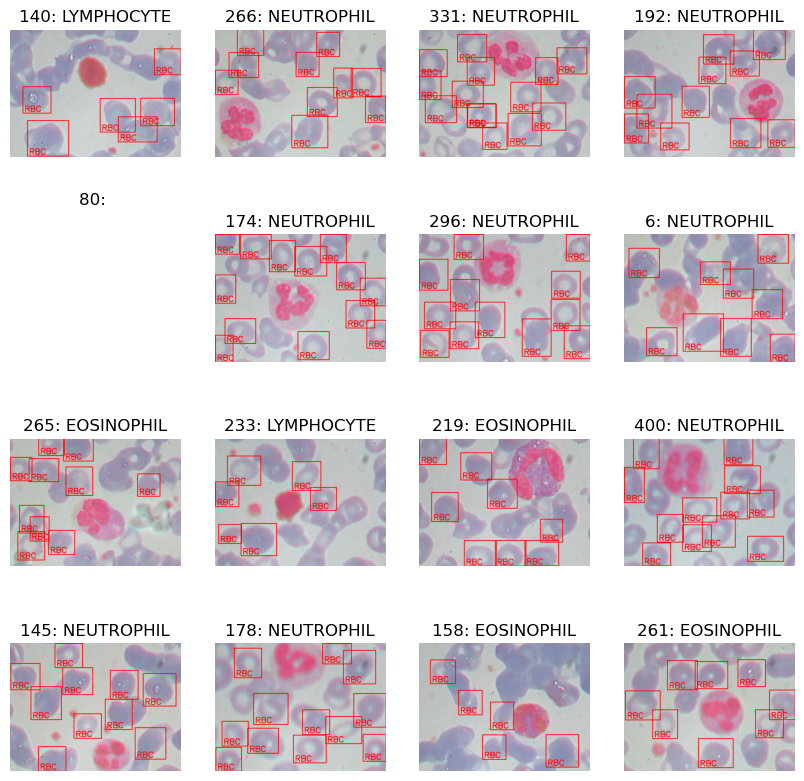

In [6]:
original_data = OriginalDataset(orig_img_path, orig_labels_csv, orig_ann_path)
nrows = 4
ncols = 4

print(f"Length of original dataset: {len(original_data)}")

# Taking random indics from the given data
indics = random.sample(list(range(len(original_data))), k=nrows * ncols)
indics = np.array(indics).reshape(nrows, ncols)

# Plotting the images
fig, axes = plt.subplots(nrows, ncols, figsize=(8, 8))

for i in range(nrows):
    for j in range(ncols):
        eg_img, eg_label, eg_ann = original_data[indics[i, j]]
        for anns in eg_ann:
            eg_img = cv2.rectangle(
                eg_img,
                (anns['xmin'], anns['ymin']),
                (anns['xmax'], anns['ymax']),
                (255, 0, 0),
                2
            )
            eg_img = cv2.putText(
                eg_img,
                anns['name'],
                (anns['xmin'] + 6, anns['ymax'] - 6),
                cv2.FONT_HERSHEY_SIMPLEX,
                1,
                (255, 0, 0),
                2
            )
        axes[i, j].set_title(f"{indics[i, j]}: {eg_label}")
        axes[i, j].set_axis_off()
        try:
            axes[i, j].imshow(eg_img)
        except TypeError as e:
            print(f"({i}, {j}): {e}")

fig.show()

In [7]:
class CustomDataset(Dataset):
    def __init__(self, path):
        img_paths = list(list_images(path))
        img_paths.sort()
        self.img_paths = img_paths
        self.images = []
        self.labels = []
        
        count = 0
        for img_path in self.img_paths:
            self.images.append(cv2.imread(img_path))
            self.labels.append(img_path.split(os.path.sep)[-2])
            
            count += 1
            if not (count % 1000):
                print(f"Read {count} images.")
        print(f"Completed reading {count} images.")
        
        self.lb = LabelBinarizer()
        self.labels = self.lb.fit_transform(self.labels)
        
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        img = self.images[idx]
        lab = self.labels[idx]
        return img, lab

In [8]:
train_ds = CustomDataset(train_img_path)
test_ds = CustomDataset(test_img_path)

Read 1000 images.
Read 2000 images.
Read 3000 images.
Read 4000 images.
Read 5000 images.
Read 6000 images.
Read 7000 images.
Read 8000 images.
Read 9000 images.
Completed reading 9957 images.
Read 1000 images.
Read 2000 images.
Completed reading 2487 images.


[0 1 0 0]


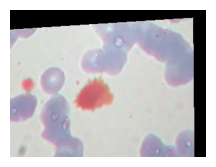

In [9]:
img, lab = train_ds[random.randint(0, len(train_ds))]

fig, ax = plt.subplots()
print(lab)
ax.imshow(img)
ax.set_axis_off()
fig.show()

In [16]:
batch_size = 32

train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
test_dl = DataLoader(test_ds, batch_size=batch_size, shuffle=True)

In [17]:
if torch.cuda.is_available():
    dev = 'cuda:0'
    torch.cuda.set_device(dev)
else:
    dev = 'cpu'
torch.cuda.is_available()

True

In [18]:
print(torch.cuda.mem_get_info())

gc.collect()

torch.cuda.empty_cache()

print(torch.cuda.mem_get_info())

(2860253184, 17071734784)
(12781879296, 17071734784)


In [19]:
sigmoid = torch.nn.Softmax(dim=1)

def compute_acc(pred, target):
    predicted = torch.argmax(pred, dim=1).cpu()
    actual = torch.argmax(torch.Tensor(target).cpu(), dim=1)
    return predicted.eq(actual).sum().float() / predicted.numel()

def get_test_sample_acc(model, test_ds, test_size=64):
    """Samples randomly from test data and computes accuracy of model
    
    @param model: The pytorch model
    @param test_ds: The pytorch Test dataset instance
    @param test_size: (default = 64) The test sample size
    @return: Accuracy over random sample from test data
    """
    model.eval()
    
    indics = random.sample( list(range(len(test_ds))) , k=test_size)
    correct_preds = 0
    for i in indics:
        image, label = test_ds[i]
        image = torch.Tensor(np.einsum("ijk->kij", image)).to(dev)
        label = torch.Tensor(label)
        
        pred_label = model( torch.unsqueeze(image, 0) )
        pred_label = sigmoid(pred_label)[0]
        
        if torch.argmax(pred_label) == torch.argmax(label):
            correct_preds += 1
    
    model.train()
    return (correct_preds/test_size)

In [20]:
model = vgg19(num_classes=train_ds.lb.classes_.size)
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0003, betas=(0.9, 0.999))

model.to(dev)
model.train()
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

In [21]:
no_of_epochs = 3

epoch_loss = []
granular_loss = []

epoch_acc = []
granular_acc = []

test_sample_acc = []
# granular_test_acc = []

model.train()

for epoch_num in range(1, no_of_epochs+1):
    batch_count = 0
    img_count = 0
    
    cur_epoch_loss = 0
    cur_epoch_acc = 0
#     cur_test_sample_acc = 0
    
    for batch in train_dl:
        images, labels = batch
        images = torch.Tensor(np.einsum("ijkl->iljk", images)).to(dev)
        labels = torch.Tensor(labels).to(dtype=torch.float, device=dev)
        
        pred_labels = model(images)
        
        loss = loss_fn(pred_labels, labels)
        acc = compute_acc(pred_labels, labels)
#         test_acc = get_test_sample_acc(model, test_ds)
        
        granular_loss.append(loss.item())
        granular_acc.append(acc)
#         granular_test_acc.append(test_acc)
        
        cur_epoch_loss += loss.item()
        cur_epoch_acc += acc
#         cur_test_sample_acc += test_acc
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        img_count += images.shape[0]
        batch_count += 1
        
        if not (batch_count % 10):
            print(f"Batch {batch_count} | Loss: {loss.item()} | Accuracy: {acc}")
    
    epoch_loss.append(cur_epoch_loss / batch_count)
    epoch_acc.append(cur_epoch_acc / batch_count)
    
    test_sample_acc.append(get_test_sample_acc(model, test_ds))
    
    print(f"Epoch {epoch_num:02} | Loss: {epoch_loss[-1]} | Accuracy: {epoch_acc[-1]} | Test Accuracy: {test_sample_acc[-1]}")
    print()
    
    if not (epoch_num % 10):
        torch.save(model.state_dict(), os.path.join(output_dir, f"torch_vgg19_blood_cells_{epoch_num:03}.pt"))
        print(f"Saved model state at epoch {epoch_num}")
        print()
torch.save(model.state_dict(), os.path.join(output_dir, f"torch_vgg19_blood_cells_{epoch_num:03}.pt"))
print(f"Saved model state at epoch {epoch_num}")
print()

Batch 10 | Loss: 1.3985998630523682 | Accuracy: 0.28125
Batch 20 | Loss: 1.4081170558929443 | Accuracy: 0.09375
Batch 30 | Loss: 1.3832812309265137 | Accuracy: 0.28125
Batch 40 | Loss: 1.3788952827453613 | Accuracy: 0.40625
Batch 50 | Loss: 1.3991539478302002 | Accuracy: 0.25
Batch 60 | Loss: 1.3862571716308594 | Accuracy: 0.28125
Batch 70 | Loss: 1.386880874633789 | Accuracy: 0.21875
Batch 80 | Loss: 1.3857908248901367 | Accuracy: 0.25
Batch 90 | Loss: 1.3878676891326904 | Accuracy: 0.1875
Batch 100 | Loss: 1.3801710605621338 | Accuracy: 0.46875
Batch 110 | Loss: 1.386383056640625 | Accuracy: 0.21875
Batch 120 | Loss: 1.3872308731079102 | Accuracy: 0.28125
Batch 130 | Loss: 1.3863768577575684 | Accuracy: 0.28125
Batch 140 | Loss: 1.3848793506622314 | Accuracy: 0.375
Batch 150 | Loss: 1.386371374130249 | Accuracy: 0.1875
Batch 160 | Loss: 1.3910908699035645 | Accuracy: 0.28125
Batch 170 | Loss: 1.385318398475647 | Accuracy: 0.25
Batch 180 | Loss: 1.3849687576293945 | Accuracy: 0.375
Ba

In [ ]:
!curl https://raw.githubusercontent.com/pytorch/xla/master/contrib/scripts/env-setup.py -o pytorch-xla-env-setup.py
!python pytorch-xla-env-setup.py --version nightly --apt-packages libomp5 libopenblas-dev

In [ ]:
import torch_xla
import torch_xla.distributed.parallel_loader as pl
import torch_xla.distributed.xla_multiprocessing as xmp
import torch_xla.core.xla_model as xm

In [ ]:
loss_fn = torch.nn.CrossEntropyLoss()

def train_epoch(data_loader, model, optimizer, device):
    model.train()
    
    granular_loss = []
    for images, labels in data_loader:
        images = torch.Tensor(np.einsum("ijkl->iljk", images)).to(device)
        labels = labels.to(device)
        
        pred_label = model(images)
        loss = loss_fn()
        
        if loss
        
        optimizer.zero_grad()
        loss.backward()
        xm.optimizer_step(optimizer)
    model.eval()

def test_epoch(data_loader, model, device):
    model.eval()